# Detecting Error Tolerant Subexpressions in 1D functions

One approach to approximate computation is to remove superfluous computations which do not contribute significantly to the final result of a function.

For example, if we are outputting to a 8-bit per pixel display then any floating-point computation that results in a change of less than 1/255 could be considered to not have a significant impact on the final result as it does not result in a change of value. 

Given a function:
*f(x, n) = x + x/10 + x/100 ... + x/10^n*

We know intuitively that at some point the change in value for each subsequent addition will not make a significant change in the final result.
So, if we know the result of *f* is error tolerant to +-0.1 and the range of x inputs is (0,10) then every addition after x/10 will be insignicant to our final result.

This can be trivially seen for simple linear functions like this, but for more complex non-linear problems we need to use a more robust approach to fully understand how each subexpression can effect others. To solve this, we need to analyse the impact of each expression in the total function on the final output. This is called differentiation by finite differences:

dy/dx = ( f(x + h) - f(x) ) / h

This will tell us the relative difference in input based on the change of a single value. If we omit the division by *h* we get the absolute change in value.

In this example we are changing the input to the function and calculating its gradient. However, as we have access to the AST for the function *f* we could apply the *+h* to any step in the AST (Abstract Syntax Tree). This would tell us how much a change at any point the AST would have on the final result.

From this we can see that if changing a specific part of the function does not change the output value significantly for a certain range of inputs then we could omit that part of the function without a negative impact.

This Julia example shows us how this can be measured and identified using standard functions of the Julia language.






## Framework

We start with importing *Plots* so that we can visualise the differentiated result.

Next we provide some global values and functions to inject into the functions we are going to analyse.

The import function here is *FuzzInput*. *FuzzInput* takes a current value and adjusts it based on the global offset. This Fuzzing is what will be used to perform the differentiation. We will take an existing expression, such as x^2, and change it to FuzzInput(x^2). This will allow us to compare how slight changes changes to this function in *x* and *h* result in different final outputs.

We also provide *TrackMinMax* so that we can instrument expressions to determine the min and max output over a given range of inputs. This is to aid in investigating the behaviour of the function.

In [1]:
using Plots

globalFuzzMin = -0.01
globalFuzzMax =  0.01
globalFuzzVal =  0.0
FuzzInput(t) = t + globalFuzzVal;
ZeroExpr(t) = 0

minValue =  99999999
maxValue = -99999999

function PrintMinMax()
    @show minValue
    @show maxValue    
end

function ResetGlobalMinMax()
    global minValue
    global maxValue   
    minValue = 999999999
    maxValue = -99999999
end

function TrackMinMax(t)
    global minValue
    global maxValue
    minValue = t < minValue ? t : minValue
    maxValue = t > maxValue ? t : maxValue
    return t
end;

### Instrumentation

*FindAttachmentPoints* and *ReplaceTree* are the main functions used to inject the fuzzing code into an existing function.
    
*FindAttachmentPoints* walks through the expression tree of the target function and returns a list of subexpressions which are compatible with Fuzzing. *ReplaceTree* is then used with the ID of a subexpression *FindAttachmentPoints* to replace that expression *x* with *FuzzInput(x)*.
    

In [63]:
function FindAttachmentPoints(expr, maxid = 0, symbolExclusion = names(Base))
    ids = []
    id = maxid
    if(typeof(expr) == Expr)
         # Handle expressions
         push!(ids,(id,expr))   
         for i in 1:length(expr.args)
             id = id + 1
             newIds, id = FindAttachmentPoints(expr.args[i], id, symbolExclusion)
             ids = vcat(ids, newIds)
         end
    elseif(typeof(expr) == Symbol)
         # Handle Symbols - We cant fuzz functions directly. Only the result through :call
         if ( !(expr in symbolExclusion) )
             push!(ids,(id,expr))
         end
    elseif ( isa( (expr), Number ) )
         push!(ids, (id,expr))  
    else
         println("Unknown type submitted: $(typeof(expr))")
    end
        
    return ids, id
end

function ReplaceTree(expr, replacementID, functionName, maxid = 0)
    id = maxid
    if(id == 12345678) return 12345678 end
    if(typeof(expr) == Expr)
         # Handle expressions
         for i in 1:length(expr.args)
             id = id + 1
             if(id == replacementID)
                 fuzzTarget = expr.args[i]
                 replacementExpr = Expr(:call, functionName, fuzzTarget)
                 expr.args[i] = replacementExpr
                 return 12345678
             elseif(id > replacementID)
                 if(id != 12345678)
                     println("$id -> Unable to replace function: $(expr)")
                 end
                 return 12345678
             end
            
             id = ReplaceTree(expr.args[i], replacementID, functionName, id)
             if(id == 12345678) return 12345678 end
         end
    end
    
    id
end


ReplaceExpression (generic function with 2 methods)

### Testing

Now that we can instrument the function we want to be able to automate instrumenting every possible attachment point. *FuzzTestAll* is the macro which allows this. It generates a list of all the possible attachment points for a given function and then performs differentiation for those points for a given range of *x* and *h*.

The result of this test is a graph for each attachment point. This shows the maximum change in *y* of specific *x* values for a changing value of *h*.

From each graph we can say that for our target usage range of *x* in the function *f*, if the change in *y* is less than our accepted tolerance then the subexpression is either equal to a constant or can be replaced by a faster function which results in a larger error (within the now established tolerance for that subexpression point).

In [32]:
macro FuzzTestAll(expr, inputRange = 0.0:0.01:1.0, fuzzRange  = -0.5:0.01:0.5, verbose = false)
    quote
        if($verbose) println("Find Attachment Points") end
        res, maxid       = FindAttachmentPoints($expr)
        attachPointCount = length(res)
        if($verbose) println("Found $attachPointCount attach points (2 Invalid)") end

        resultGraphs= []
        for p in res[3:end]
            if($verbose) println(p) end
            tCopyFuzz = deepcopy($expr)
            ReplaceTree(tCopyFuzz, p[1] , :FuzzInput)
            execFunc  = eval(tCopyFuzz)

            function testPointLocal(x, fuzz)
                global globalFuzzVal
                globalFuzzVal = 0.0
                sourceResult  = execFunc(x)
                globalFuzzVal = fuzz
                fuzzResult    = execFunc(x)      
                dif           = (sourceResult - fuzzResult)
            end 

            gr = plot($inputRange, $fuzzRange, (x,y)-> testPointLocal(x,y), st=:surface, title="(ID:$(p[1])) $(p[2])", xlabel="Input", ylabel="Fuzz", zlabel="Error")
            push!(resultGraphs, gr)
        end

        resultGraphs
    end
end

macro displayall(graphlist)
    quote
        for g in $graphlist
            display(g)
        end
    end
end

@displayall (macro with 1 method)

### Simple Example

Using our example from the introduction we show that the *x* in the subexpression *x/10* has a maximum impact on the final result of 0.1 which just touches our tolerance of 0.1. But that the *x/100* has a maximum impact of 0.01 which is under our threshold.

As we know that this is the first differential and that value has no impact we can replace this subexpression with 0.

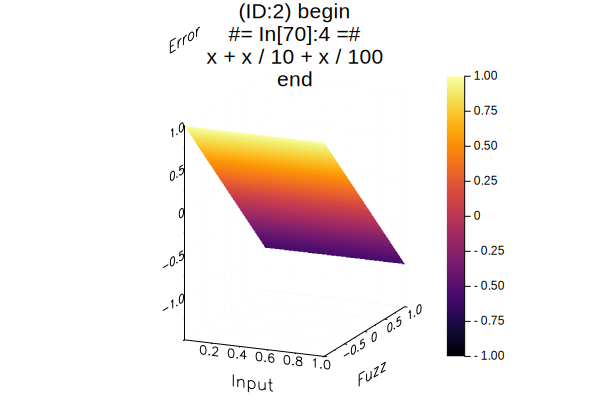

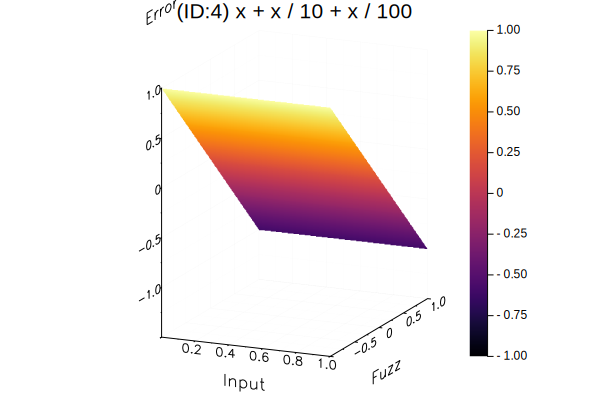

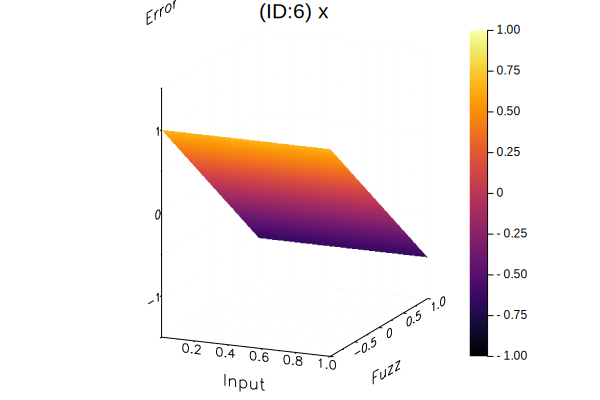

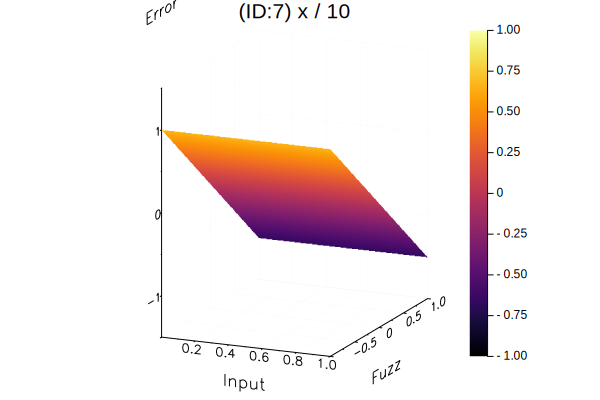

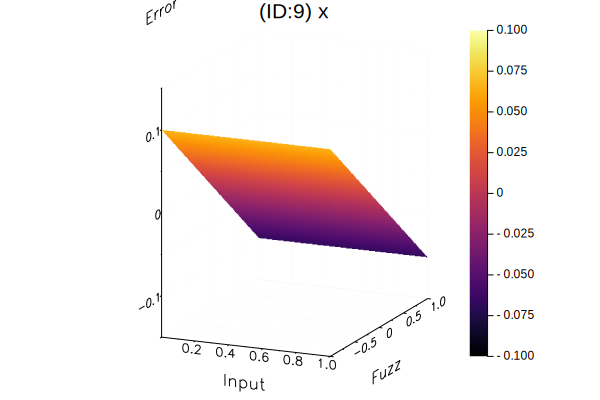

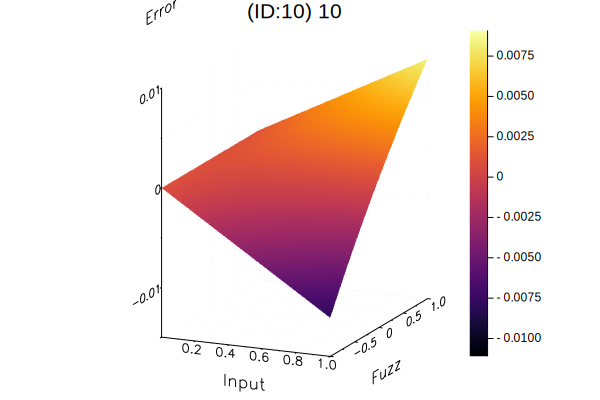

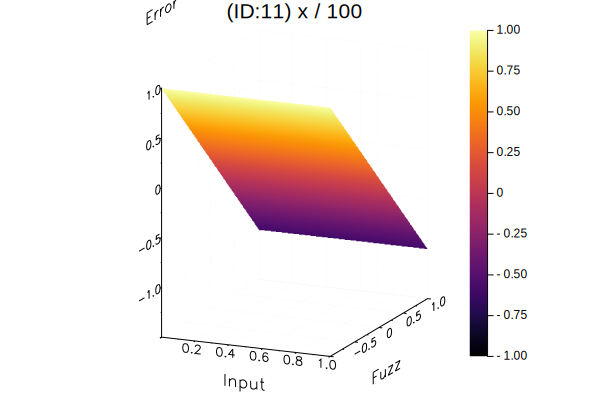

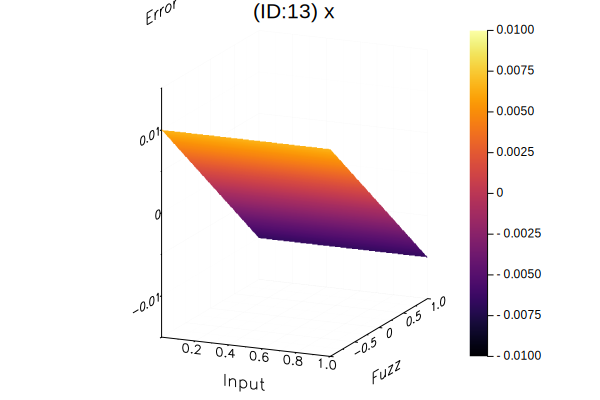

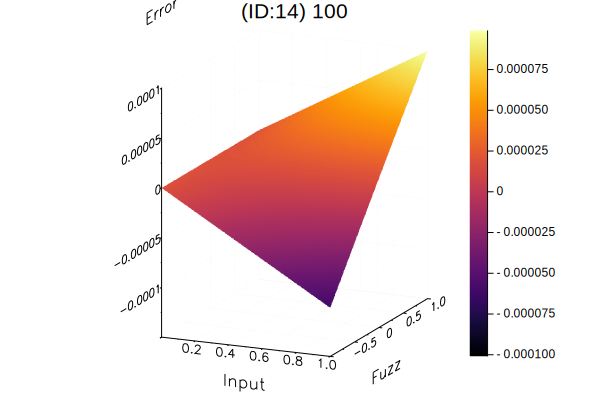

Unknown type submitted: LineNumberNode


In [70]:
# Testing Trivial Example
# Input range (0,1)
# Absolute Tolerance 0.1
f = :(x -> x + x/10 + x/100)
resultGraphs = @FuzzTestAll f 0.0:0.01:1.0 -1.0:0.01:1.0
@displayall(resultGraphs)

Now that we know that the *x/100* subexpression has a negligible effect on the final result. We can replace it with zero in our function.

We could also delete the function entirely, but negating it's input this way allows for further experimentations if this was a more complex function.

In [68]:
# Replacing subexpressions with constants
ReplaceTree(f, 11, :ZeroExpr)
print(f)

x->begin
        #= In[67]:4 =#
        x + x / 10 + ZeroExpr(ZeroExpr(x / 100))
    end

## More Complex Results
An example of the results from a more complex (non-linear) function.

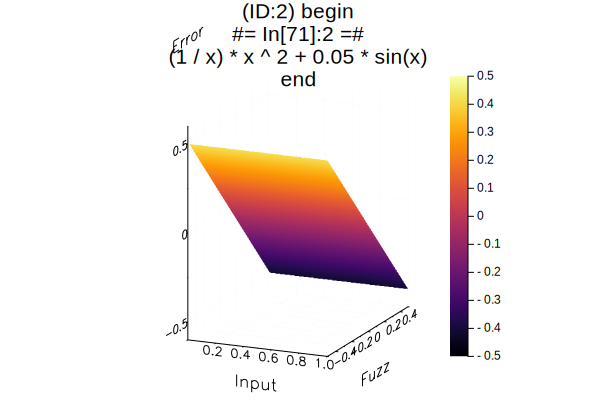

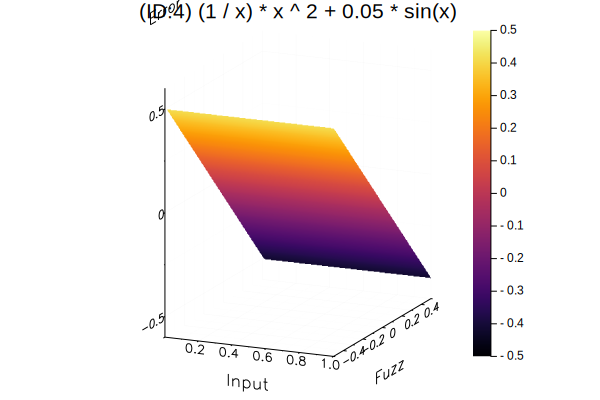

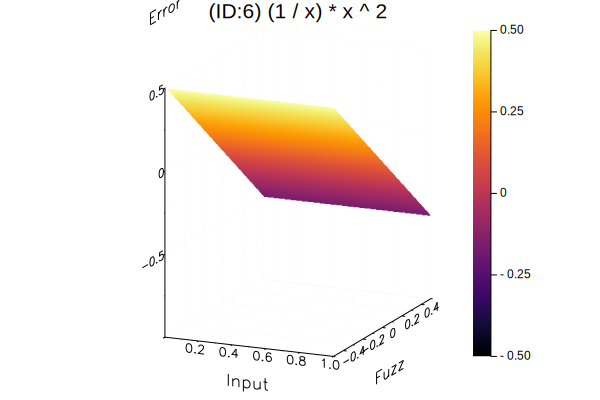

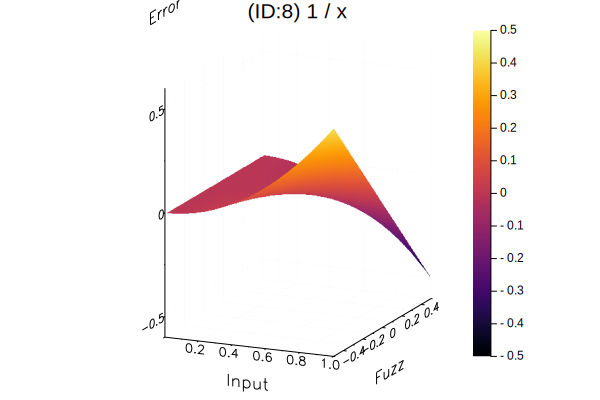

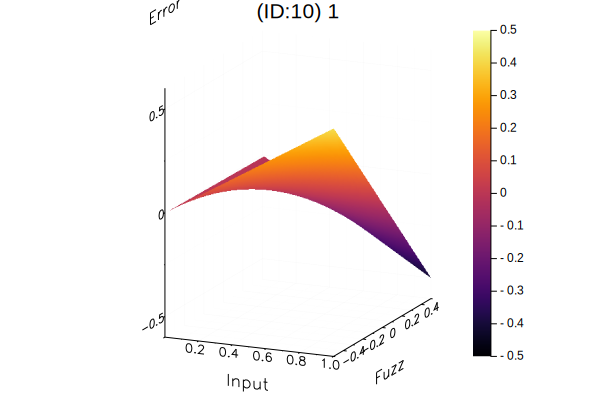

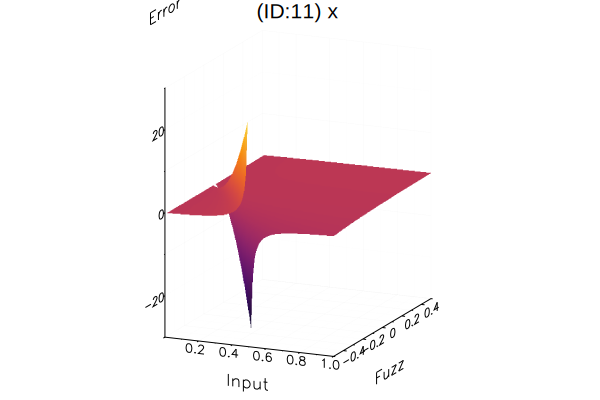

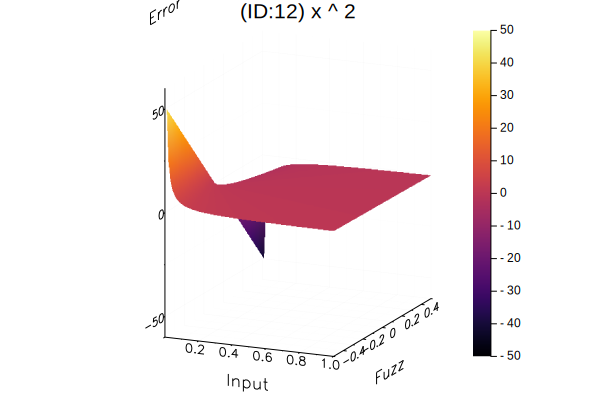

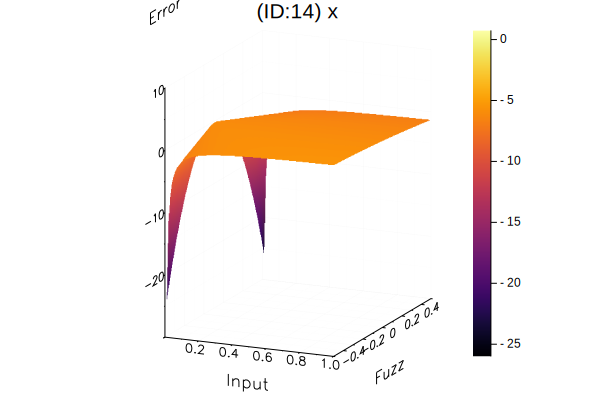

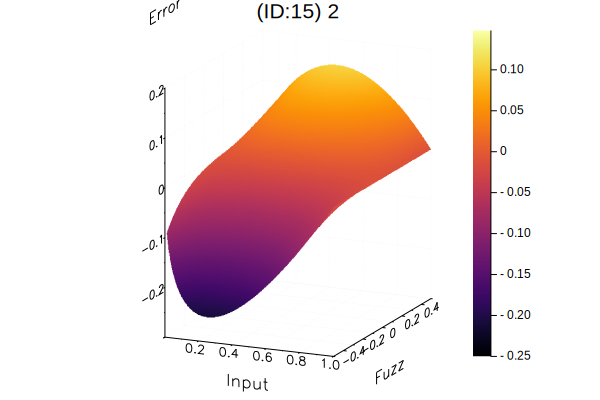

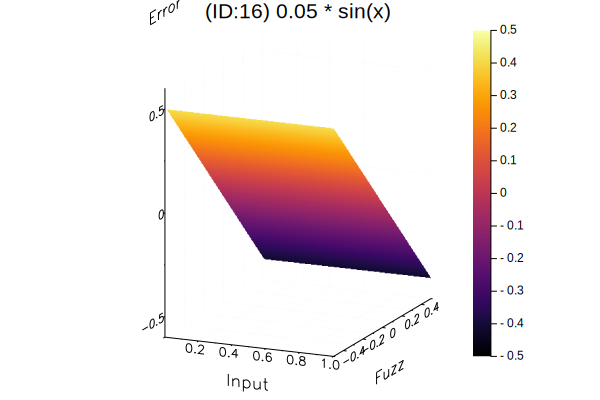

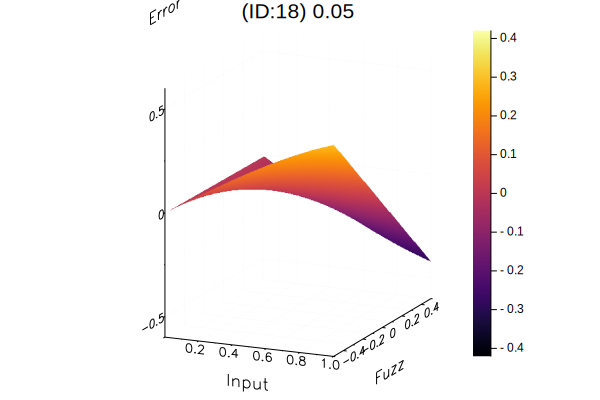

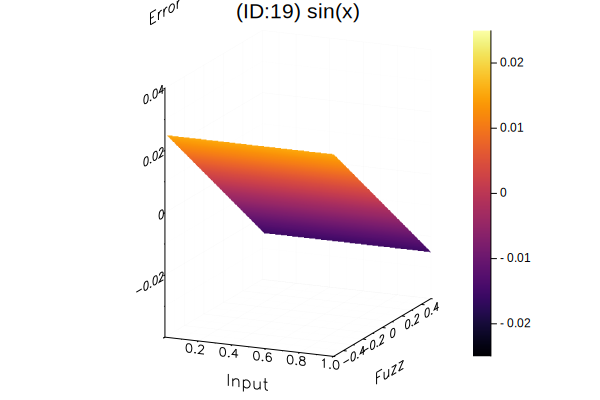

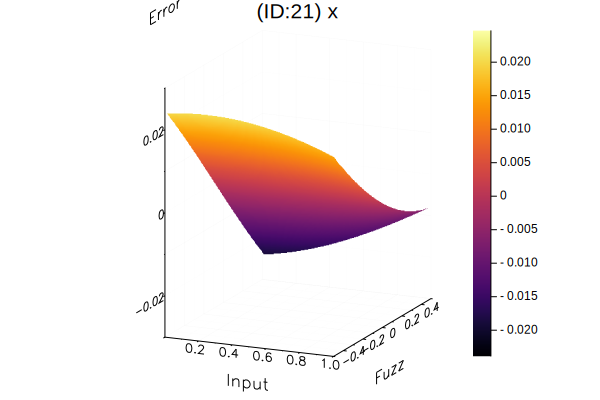

Unknown type submitted: LineNumberNode


GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
origin outside current window


In [71]:
# TEST
t = :(x -> (1/x) * (x^2) + 0.05 * sin(x))
grs = @FuzzTestAll t 
@displayall(grs)